# Imports

Sometimes the calculations in this notebook run faster if the GPU isn't enabled; I think this is especially true with some of the caching I do, so I usually run the cell below to have JAX run on CPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import adaptive_latents.transforms.utils as fin
import tqdm as tqdm
from adaptive_latents import NumpyTimedDataSource
import adaptive_latents.plotting_functions as bpf
import adaptive_latents.input_sources.datasets as datasets
import sklearn.decomposition
import pandas as pd
import adaptive_latents

# Define the Dataset to run on
Each of the sub-sections (with the `<h2>`/`##` headings) of this part of the notebook imports a single dataset. If you run all of them in order only the last dataset (currently jPCA) will carry over to the next section, so you have to choose which cells you want to execute here.

Each dataset-specific (jPCA/Buzaki/Indy/Fly/Musal) section constructs a `pre_datasets` variable, which is turned into a `datasets` dictionary in the "For All" cell. The `datasets` variable is how the rest of the notebook interacts with the data, and the `input_keys` and `output_keys` determine which variables get fed into bubblewrap and/or regressed.

**To define a new set of variables**: Each key-value pair of the `pre_datasets` variable in every section is one possible set of variables to regress on or be a target of regression. The keys have a special format: 
```python
key_string = f"{human_readable_name} # {'i' if should_be_input} {'o' if should_be_regressed} {'🌀' if should_add_shuffled_copy}"
```
Note that the "i" "o" and "🌀" tags can be added in any combination and any order (see the "run this for all datasets" cell). So this means that the key `'beh # i'` will be called "beh" in the labels of graphs and will only be used as an input to bubblewrap and not something that can be regressed. Note the "🌀" tag is strictly additive; it basically means "anything you were going to do with this dataset, also do that with a shuffled copy and keep the results for both".

The three functions I use the most on the right-hand-sides are `fin.prosvd_data` (which does proSVD), `fin.zscore` (which does a clipped running zscore), and `fin.clip` (which realigns datasets of different lengths). Note that due to the way I'm caching `prosvd_data`, it only takes keyword arguments.

In [2]:
dataset_chosen = "indy"

## Fly

In [3]:
if dataset_chosen == "fly":
    obs, raw_behavior, obs_t, beh_t = datasets.construct_fly_data(datasets.individual_identifiers["fly"][0])
    
    resampled_behavior = fin.resample_matched_timeseries(raw_behavior, obs_t, beh_t)
    beh = resampled_behavior
    
    pre_datasets = {
        # 's(z(obs),1) # i': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=1, init_size=30),
        # 's(z(obs),2) # i': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=2, init_size=30),
        # 's(z(obs),3) # i': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=3, init_size=30),
        's(z(obs),4) # i o': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=4, init_size=30),
        # 's(z(obs),5) # i': fin.prosvd_data(input_arr=fin.zscore(obs, 10), output_d=5, init_size=30),
        
        's([z(obs),beh],4) # i': fin.prosvd_data(input_arr = np.hstack(fin.clip(fin.zscore(obs, 10), beh)), output_d=4, init_size=30),
    
        
        'beh # o': beh,
        'z(beh) # i': fin.zscore(input_arr=beh, init_size=20),
    
        # 's(obs,1) # o': fin.prosvd_data(input_arr=obs, output_d=1, init_size=30),
        # 'z(beh) # i': fin.zscore(beh, 10),
        # 's(z(beh),1) # o': fin.prosvd_data(input_arr=fin.zscore(beh, 10), output_d=1, init_size=20),
        # 's(z([obs,beh]),5) # i': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=5, init_size=20),
        # 's(z([obs,beh]),1) # o': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=1, init_size=20),
    }
    
    for key, value in pre_datasets.items():
        pre_datasets[key] = fin.clip(value, beh_t)

## Buzsaki

In [4]:
if dataset_chosen == "buzaki":
    obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_buzaki_data(individual_identifier=adaptive_latents.input_sources.datasets.individual_identifiers["buzaki"][0], bin_width=0.03)
    ###
    resampled_behavior = fin.resample_matched_timeseries(raw_behavior, bin_centers, beh_t)
    hd = np.arctan2(resampled_behavior[:,0] - resampled_behavior[:,2], resampled_behavior[:,1] - resampled_behavior[:,3])
    beh = resampled_behavior[:,:2]
    ###
    pre_datasets = {
        's([obs,pos],6) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=6, init_size=50),
        's(z([obs,pos]),4) # i': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=4, init_size=50),
        's(obs,6) # i o': fin.prosvd_data(input_arr=obs, output_d=6, init_size=50),
        'pos # i o' : beh,
        
    
        'hd # o': hd.reshape(-1,1),
        # 'pca(obs,2) # i o' : sklearn.decomposition.PCA(n_components=2).fit_transform(obs),
    }
    
    for key, value in pre_datasets.items():
        pre_datasets[key] = fin.clip(value, beh_t)


## Indy

In [5]:
if dataset_chosen == "indy":
    obs, beh, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_indy_data(
        adaptive_latents.input_sources.datasets.individual_identifiers["indy"][0],
        bin_width=0.03,
    )
    
    resampled_behavior = fin.resample_matched_timeseries(beh, bin_centers, beh_t)
    beh, beh_t = resampled_behavior, bin_centers
    
    pre_datasets = {
        'beh # i o': [beh, beh_t],
        # 's([obs,beh],6) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=6, init_size=20),
        's(obs,6) # i o': fin.clip(fin.prosvd_data(input_arr=obs, output_d=6, init_size=30), bin_centers),
    
    }

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_013393346625801.pickle


## Musal

In [6]:
if dataset_chosen == "musal":
    ca, vid, t_ca, t_vid = adaptive_latents.input_sources.datasets.generate_musal_dataset(cam=1, video_target_dim=6, resize_factor=1, prosvd_init_size=100)
    
    resampled_vid = fin.resample_matched_timeseries(vid, t_ca, t_vid)
    
    pre_datasets = {
        's(ca,6) # i o': fin.prosvd_data(input_arr=ca, output_d=6, init_size=30),
        's(vid,6) # i o': fin.prosvd_data(input_arr=resampled_vid, output_d=6, init_size=30),
        's([ca,s(vid,6)],6) # i': fin.prosvd_data(input_arr=np.hstack([ca, resampled_vid]), output_d=6, init_size=30),
    }
    
    for key, value in pre_datasets.items():
        pre_datasets[key] = fin.clip(value, t_ca)

## jPCA

In [7]:
if dataset_chosen == "jPCA":
    obs, beh = fin.get_from_saved_npz("jpca_reduced_sc.npz")
    obs_t = beh_t = np.arange(beh.shape[0])
    
    pre_datasets = {
        's(obs,4) # i o': fin.prosvd_data(input_arr=obs, output_d=4, init_size=30),
        's([obs,beh],4) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=4, init_size=30),
        'beh # i o': beh,
    }
    
    for key, value in pre_datasets.items():
        pre_datasets[key] = fin.clip(value, beh_t)

# Run Stuff

## Run this for all datasets
This constructs the `datasets` variable, which the rest of the script will use.

In [8]:
with_randoms = {}
for key, value in pre_datasets.items():
    k = key.replace("🌀", "")
    with_randoms[k] = value
    if "🌀" in key:
        k, tags = k.split("#")
        k = k.strip()
        with_randoms[f"shuf({k}) #{tags.strip()}"] = (*fin.shuffle_time(value[0]), value[1])

datasets = {}
input_keys = []
output_keys = []
for key, value in with_randoms.items():
    k, tags = key.split("#")
    k = k.strip()
    datasets[k] = value
    assert np.all(np.isfinite(value[0]))
    if "i" in tags:
        input_keys.append(k)
    if "o" in tags:
        output_keys.append(k)
        if "b" in tags:
            a, t = value
            for i in range(a.shape[1]):
                new_k = k + f"[:,{i}]"
                datasets[new_k] = (a[:,i:i+1],t)
                output_keys.append(new_k)

## Histograms
The regressions tend to do better when the input and ou

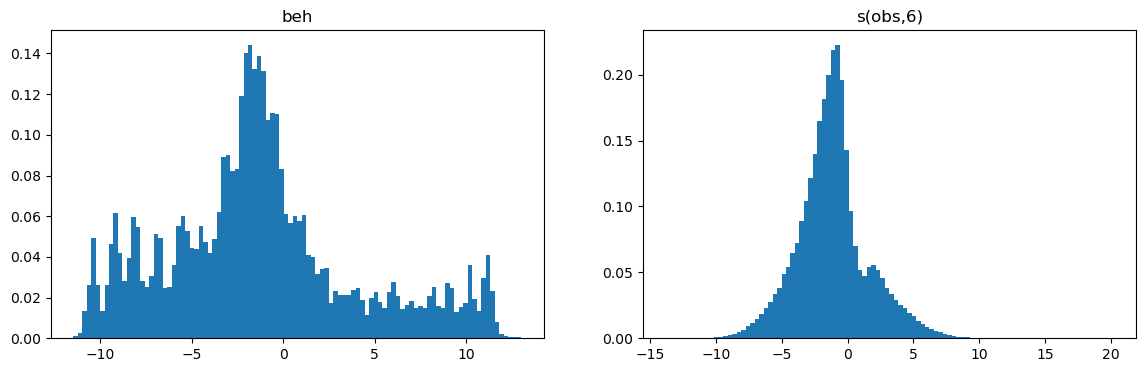

In [9]:
# histograms for input datasets; if these are un-nice, bubblewrap will sometimes get nan's in the alphas and fail.

fig, ax = plt.subplots(ncols=len(input_keys), nrows=1, figsize=(14,4), squeeze=False)

for i, key in enumerate(input_keys):
    ax[0][i].hist(datasets[key][0].flatten(), bins=100, density=True)
    ax[0][i].set_title(key)

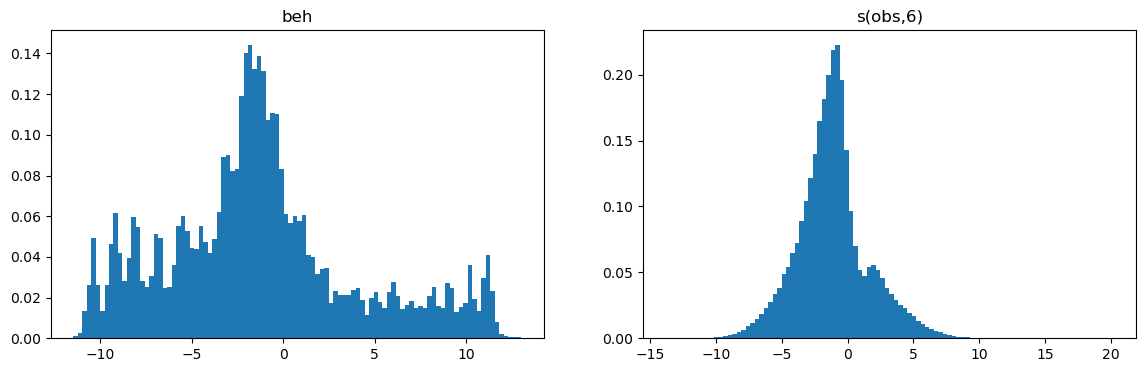

In [10]:
# histograms for output datasets; note there will often be repeats

fig, ax = plt.subplots(ncols=len(output_keys), figsize=(14,4), squeeze=False)
for i, key in enumerate(output_keys):
    ax[0][i].hist(datasets[key][0].flatten(), bins=100, density=True)
    ax[0][i].set_title(key)

## Run Table

In [11]:
@fin.save_to_cache("simple_bw_run")
def simple_bw_run(input_arr, t, time_offsets, bw_params):
    bw = adaptive_latents.Bubblewrap(input_arr.shape[1], **bw_params)
    br = adaptive_latents.BWRun(bw, adaptive_latents.NumpyTimedDataSource(input_arr, t, time_offsets), show_tqdm=True)
    br.run(save=True)
    return br

def evaluate(i,o, maxlen=10_000, bw_params=adaptive_latents.default_parameters.default_jpca_dataset_parameters, seed=0):
    """
    run bubblewrap on dataset i (the inputs) and run a regression on dataset o (the target outputs)
    
    Note that bubblewrap is run and then the regression is done post-hoc. This is so the bubblewrap run can be cached.
    
    parameters:
        i: the input to bubblewrap; an element of the datasets dictionary (really tuple of `(datapoints, timestamps)`)
        o: same as i, but the a set of variables to try to predict
        maxlen: the point at which to cut off bubblewrap if the dataset is large
        bw_params: the hyperparameters to pass to bubblewrap
        
    returns:
        br: the bubblewrap run (this has lots of useful information)
        pred: the predictions from the regression
        true: the target values from the regression (so basically a slice of the `o` input)
        times: the timestamps for the regression predictions
    """
    i, i_t, o, o_t = fin.clip(*i, *o, maxlen=maxlen)
    
    o_dt = np.median(np.diff(o_t))
    i_dt = np.median(np.diff(i_t))
    n_steps = int(np.ceil(o_dt/i_dt))
        
    br = simple_bw_run(input_arr=i,t=i_t, time_offsets=[0,n_steps], bw_params=bw_params)
    
    
    out_ds = adaptive_latents.NumpyTimedDataSource(o, o_t, (n_steps,))
    reg_class = adaptive_latents.regressions.auto_regression_decorator(adaptive_latents.regressions.SymmetricNoisyRegressor, n_steps=1, autoregress_only=False)
    reg = reg_class(input_d=br.bw.N, output_d=o.shape[1])
    
    br.add_regression_post_hoc(reg, out_ds)
    pred = br.h.beh_pred[n_steps]
    true = br.h.beh_pred[n_steps] - br.h.beh_error[n_steps]
    times = br.h.reg_offset_t[n_steps]
    return br, pred, true, times


In [12]:
%%time
# this cell evaluates each element of the table specified above using the `evaluate` function

bw_params = dict(    
    adaptive_latents.default_parameters.default_jpca_dataset_parameters, 
num=100,
eps=1e-3,
step=1,
num_grad_q=3,
)

results = {}
brs = {}
true_values = {}
for okey in output_keys:
    results[okey] = {}
    brs[okey] = {}
    true_values[okey] = {}
    for ikey in input_keys:
        print(f"{okey= } {ikey= }")

        br, pred, true, times = evaluate(datasets[ikey], datasets[okey], maxlen=5_000, bw_params=bw_params)

        results[okey][ikey] = pred
        brs[okey][ikey] = br
        true_values[okey][ikey] = (true, times)

okey= 'beh' ikey= 'beh'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_979765766027050.pickle
okey= 'beh' ikey= 's(obs,6)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_544131091066265.pickle
okey= 's(obs,6)' ikey= 'beh'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_979765766027050.pickle
okey= 's(obs,6)' ikey= 's(obs,6)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_544131091066265.pickle
CPU times: user 1min 31s, sys: 2min 20s, total: 3min 52s
Wall time: 9.68 s


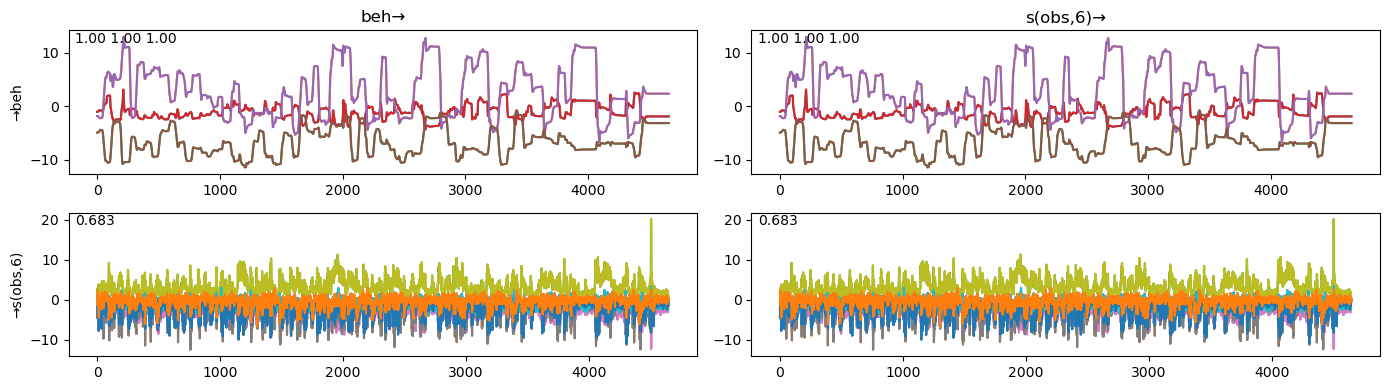

In [13]:
# this cell plots the table of results

def get_corrs_from_br(br):
    offset = br.output_ds.time_offsets[-1]
    
    first_pred_idx = np.nonzero(~np.all(np.isnan(br.h.beh_error[offset]),axis=1))[0][0]
    n_samples_before_end = (br.h.beh_error[offset].shape[0] - first_pred_idx)//2
    
    lh_predicted = br.h.beh_pred[offset][-n_samples_before_end:]
    lh_true = br.h.beh_pred[offset][-n_samples_before_end:] - br.h.beh_error[offset][-n_samples_before_end:]
    
    corrs = [np.corrcoef(lh_true[:,j], lh_predicted[:,j])[0,1] for j in range(lh_true.shape[1])]
    return corrs

fig, ax = plt.subplots(nrows=len(output_keys), ncols=len(input_keys), figsize=(14,2*len(output_keys)), layout='tight', squeeze=False)

s = slice(-1)

for row, okey in enumerate(output_keys):
    ax[row,0].set_ylabel("→" + okey)
    for col, ikey in enumerate(input_keys):
        true, times, predicted = fin.clip(*true_values[okey][ikey], results[okey][ikey])
        
        br = brs[okey][ikey]

        corrs = get_corrs_from_br(br)

        ax[row,col].plot(true[s])
        ax[row,col].plot(predicted[s])
        
        if true.shape[1] < 4:
            corrs = " ".join([f"{c:.2f}" for c in corrs])
        else:
            corrs = f"{np.mean(corrs):.3f}"
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        if row == 0:
            ax[0,col].set_title(ikey +  "→")

## Table summary for Sheets

In [38]:
row_to_break_out = "s(obs,4)"

In [39]:
df = pd.DataFrame(brs).T

In [40]:
def f(br):
    lh_pred, lh_true, _ = br.get_behavior_last_half(br.obs_ds.time_offsets[-1])
    l = [np.corrcoef(np.squeeze([lh_pred[:,j], lh_true[:,j]]))[0,1] for j in range(lh_true.shape[1])]
    if len(l) < 4:
        pass
    else:
        l = [np.mean(l)]
    return ", ".join([str(round(x,2)) for x in l])

In [41]:
table = df.applymap(f)
table.loc["pred"] = df.applymap(lambda x: x.log_pred_p_summary(offset=1)).mean(axis=0)
table.loc["ent"] =  df.applymap(lambda x: x.entropy_summary(offset=1)).mean(axis=0)
# the mean in the above two lines is just a formality; technically the values might be different across rows because of clipping

/tmp/ipykernel_146730/1172322258.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = df.applymap(f)
/tmp/ipykernel_146730/1172322258.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table.loc["pred"] = df.applymap(lambda x: x.log_pred_p_summary(offset=1)).mean(axis=0)
/tmp/ipykernel_146730/1172322258.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table.loc["ent"] =  df.applymap(lambda x: x.entropy_summary(offset=1)).mean(axis=0)


In [42]:
temp = {key: get_corrs_from_br(value) for key, value in brs[row_to_break_out].items()}
temp = pd.DataFrame(temp, index=[row_to_break_out + f"_{n}" for n in range(datasets[row_to_break_out][0].shape[1])])

In [43]:
pd.concat([table, temp]) # you can copy-paste this right into Sheets

,"s(obs,4)","s([obs,beh],4)",beh
"s(obs,4)",0.86,0.9,0.59
beh,0.86,0.9,0.57
pred,1.821789,-0.650424,-0.098251
ent,1.238005,1.396288,1.773525
"s(obs,4)_0",0.90518,0.922669,0.614561
"s(obs,4)_1",0.829449,0.868321,0.715155
"s(obs,4)_2",0.830188,0.881207,0.376473
"s(obs,4)_3",0.885419,0.926634,0.664297


Text(0, 0.5, 'individual r^2 per component in "s(obs,4)"')

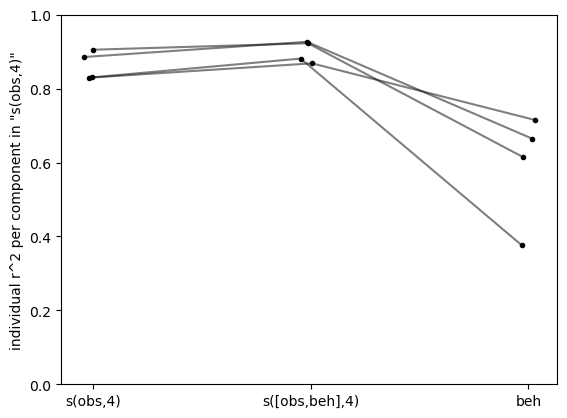

In [44]:
for i in range(temp.shape[0]):
    jitter = (rng.random(size=temp.shape[1])-.5) * .1
    plt.plot(np.arange(temp.shape[1]) + jitter, temp.iloc[i,:], 'k.')
    plt.plot(np.arange(temp.shape[1]) + jitter, temp.iloc[i,:], 'k-', alpha=.5)

plt.ylim([0,1])
plt.xticks(ticks = np.arange(temp.shape[1]), labels=temp.columns)
plt.ylabel(f'individual r^2 per component in "{row_to_break_out}"')

## Optimizing parameters

In [45]:
datasets.keys() # this is so I have the text of the keys ready to copy-paste

dict_keys(['s(obs,4)', 's([obs,beh],4)', 'beh'])

In [46]:
brs2 = [] # this is a history of bubblewrap runs; reset it when the plots are getting too full

In [49]:
%%time
brs2.append(evaluate(i=datasets['s(obs,4)'], o=datasets['s(obs,4)'], maxlen=5_000, 
                     bw_params=
                     dict(
                        adaptive_latents.default_parameters.default_jpca_dataset_parameters,
                        num=100,
                        eps=1e-5,
                        step=.5,
                        num_grad_q=4,
                     )
                    )[0])

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_433451057043727.pickle


Exception: No config file found.

In [ ]:
assert len(brs2) < 8 # this is actually fine, but just be aware that the later part of the cell slices 

colors = ['k']*(len(brs2))
colors[-1] = 'r'
bpf.compare_metrics(brs2[-7:], colors=colors[-7:], offset=1, show_legend=False)

## Choosing the better predictor

In [ ]:
datasets.keys()

In [ ]:
output_key = output_keys[0]
output_key = "s(obs,6)[:,5]"

In [ ]:
n_steps_ahead = 1

br = brs[output_key][input_keys[0]]
truth = br.behavior_pred_history[n_steps_ahead] - br.behavior_error_history[n_steps_ahead]

clipped = fin.clip(
    truth,
    *[brs[output_key][input_key].behavior_pred_history[n_steps_ahead] for input_key in brs[output_key]]
)
truth = clipped[0]
preds = np.squeeze(clipped[1:]).T


In [ ]:
preds.shape

In [ ]:
combined_estimate = []
errors = preds - truth

n_to_consider = 4

for i in range(1,len(errors)):
    a = errors[i-n_to_consider:i]
    bests = (np.abs(a) - np.abs(a).min(axis=1)[:,None]) == 0
    best_last_time = np.argmax(bests.sum(axis=0))
    combined_estimate.append(preds[i, best_last_time])
combined_estimate = np.squeeze(combined_estimate)

In [ ]:
preds, combined_estimate, truth = fin.clip(preds, combined_estimate, truth)
s = slice(1500, 1600)
plt.plot(truth[s], 'k');
plt.plot(preds[s], 'r', alpha=0.25)
plt.plot(combined_estimate[s], 'r');


In [ ]:
heights = list((errors**2).mean(axis=0)) + [(combined_estimate**2).mean()]
x = list(np.arange(errors.shape[1] + 1))
plt.bar(x, heights)
plt.ylabel("MSE")
plt.xlabel("predictor")
plt.xticks(x, labels=[xx for xx in x[:-1]] + ["combined"]);

In [ ]:
np.corrcoef(truth.T, combined_estimate[:,None].T)[0,1]